In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# 

## Pytorch Framework 
## MNIST dataset 

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np 
import pandas as pd 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional  as F

In [3]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [4]:

###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True);
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


In [5]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coordsAdam
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid(True);
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid(True);
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [6]:
print (fn_plot_torch_hist.__doc__)

None


In [7]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [8]:
###----------------------
### Some basic parameters
###----------------------

#Directories so that we can save the trained model, the outputs and the inputs
inpDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureThings/Day6/input'
outDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureThings/Day6/output'
modelDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureThings/Day6/models'
subDir = 'fashion-MNIST'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

torch.manual_seed(RANDOM_STATE)

EPOCHS = 51 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [9]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read Fashion Mnist data set

In [10]:
train_file_path = os.path.join(inpDir,'fashion-mnist_train.csv')
test_file_path = os.path.join(inpDir,'fashion-mnist_test.csv')

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [11]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
# Following columns appear to be relevant for our analysis
label = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
        }

In [14]:
# Following columns appear to be relevant for our analysis
class_labels = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
        }

## All About CUDA

In [15]:
print ('Is CUDA available: ', torch.cuda.is_available())
print ('CUDA version: ', torch.version.cuda )

Is CUDA available:  False
CUDA version:  12.1


In [16]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Custom DataSet

In [17]:
'''
In this code, we define a custom dataset called FashionDS that takes a DataFrame as input. 

'''

class FashionDS(Dataset):
    
    def __init__(self, dataframe: pd.DataFrame, device : str = device):
        
        self.df = dataframe
        self.device = device
        
        self.labels = self.df['label'].to_numpy()
        X = self.df.drop('label', axis = 1).to_numpy()
        
        self.features = X/255.      
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32, device=self.device)
        label = torch.tensor(label, dtype=torch.int64, device=self.device)
        
        return features, label

In [18]:
train_ds = FashionDS(train_df)
test_ds = FashionDS(test_df)

In [19]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
images, targets = next(iter(train_loader))

images = images.numpy()
targets = targets.numpy()

targets

array([7, 6, 4, 0, 4, 2, 8, 8, 3, 7, 3, 8, 7, 8, 3, 2, 9, 1, 9, 4, 0, 4,
       5, 1, 8, 6, 9, 5, 4, 3, 2, 6])

0.6345449673202614

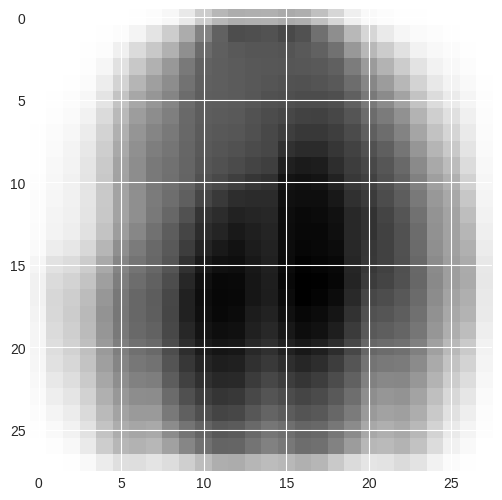

In [21]:
features_df= train_df.drop('label', axis =1)
features_df = features_df.mean(axis=0).to_numpy()/255.
plt.imshow(features_df.reshape(28,28), cmap=plt.cm.binary)
features_df.min()
features_df.max()

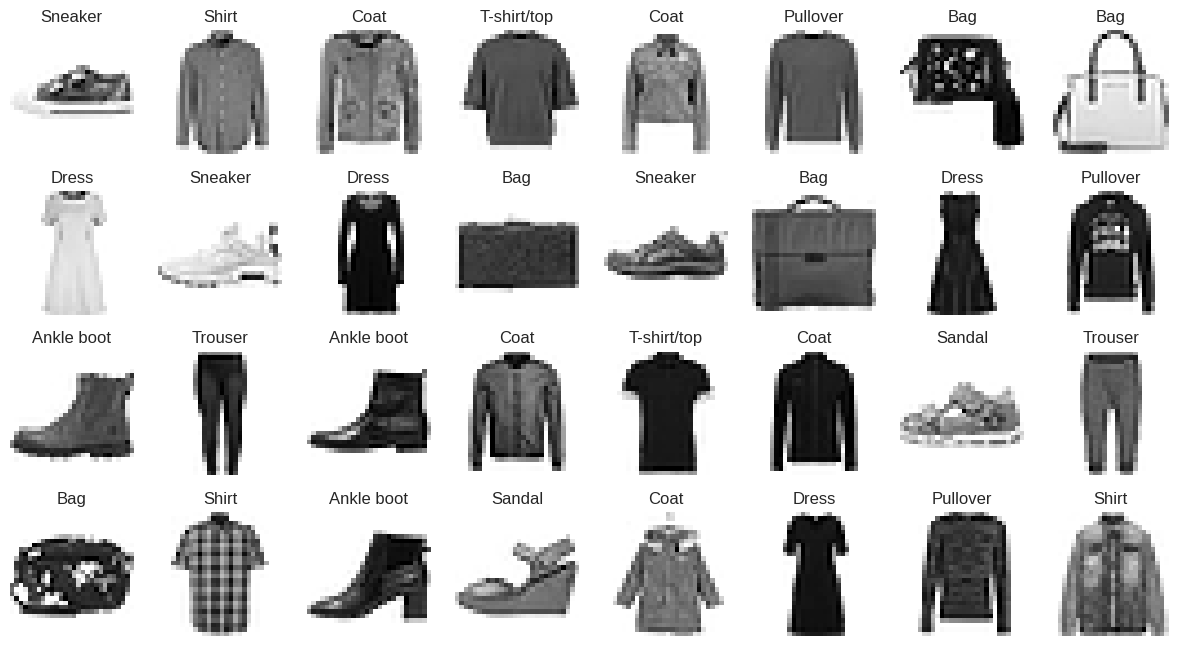

In [22]:
plt.figure(figsize=(15,8))

for i in range(BATCH_SIZE):
    plt.subplot(4,8, i+1)
    plt.imshow(images[i].reshape(28,28), cmap = plt.cm.binary)

    plt.xticks([])
    plt.yticks([])

    plt.grid(False)
    plt.title(class_labels[targets[i]])

In [23]:
input_shape = train_df.shape[1]-1
input_shape

784

In [24]:

input_shape = train_df.shape[1]-1


class Model(nn.Module):
    
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,128)
        self.activ1 = nn.Tanh()
        self.layer2 = nn.Linear(128, 32)
        self.activ2 = nn.Tanh()
        self.layer3 = nn.Linear(32, 10)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        x = self.layer2(x)
        x = self.activ2(x)
        x = self.layer3(x)
        return self.softmax(x)

net = Model(input_dim=input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (activ1): Tanh()
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (activ2): Tanh()
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [25]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA, weight_decay = 1e-5 )

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)
            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

/home/pgdai/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


At epoch 0 | Loss - train:0.5194, test:0.4063 | Acc - train:0.8211, test:0.8557
At epoch 5 | Loss - train:0.2920, test:0.3230 | Acc - train:0.8922, test:0.8830
At epoch 10 | Loss - train:0.2517, test:0.3127 | Acc - train:0.9068, test:0.8869
At epoch 15 | Loss - train:0.2268, test:0.3007 | Acc - train:0.9156, test:0.8934
At epoch 20 | Loss - train:0.2075, test:0.3176 | Acc - train:0.9223, test:0.8891
At epoch 25 | Loss - train:0.1950, test:0.3199 | Acc - train:0.9273, test:0.8923
At epoch 30 | Loss - train:0.1804, test:0.3400 | Acc - train:0.9329, test:0.8866
At epoch 35 | Loss - train:0.1725, test:0.3290 | Acc - train:0.9347, test:0.8918
At epoch 40 | Loss - train:0.1574, test:0.3351 | Acc - train:0.9424, test:0.8934
At epoch 45 | Loss - train:0.1525, test:0.3740 | Acc - train:0.9438, test:0.8824
At epoch 50 | Loss - train:0.1412, test:0.3737 | Acc - train:0.9482, test:0.8858


In [26]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.519440,0.406323,0.821133,0.8557
1,1,0.373912,0.390280,0.865033,0.8591
2,2,0.342317,0.356520,0.874800,0.8716
3,3,0.320549,0.361762,0.883350,0.8669
4,4,0.306766,0.334860,0.887367,0.8771


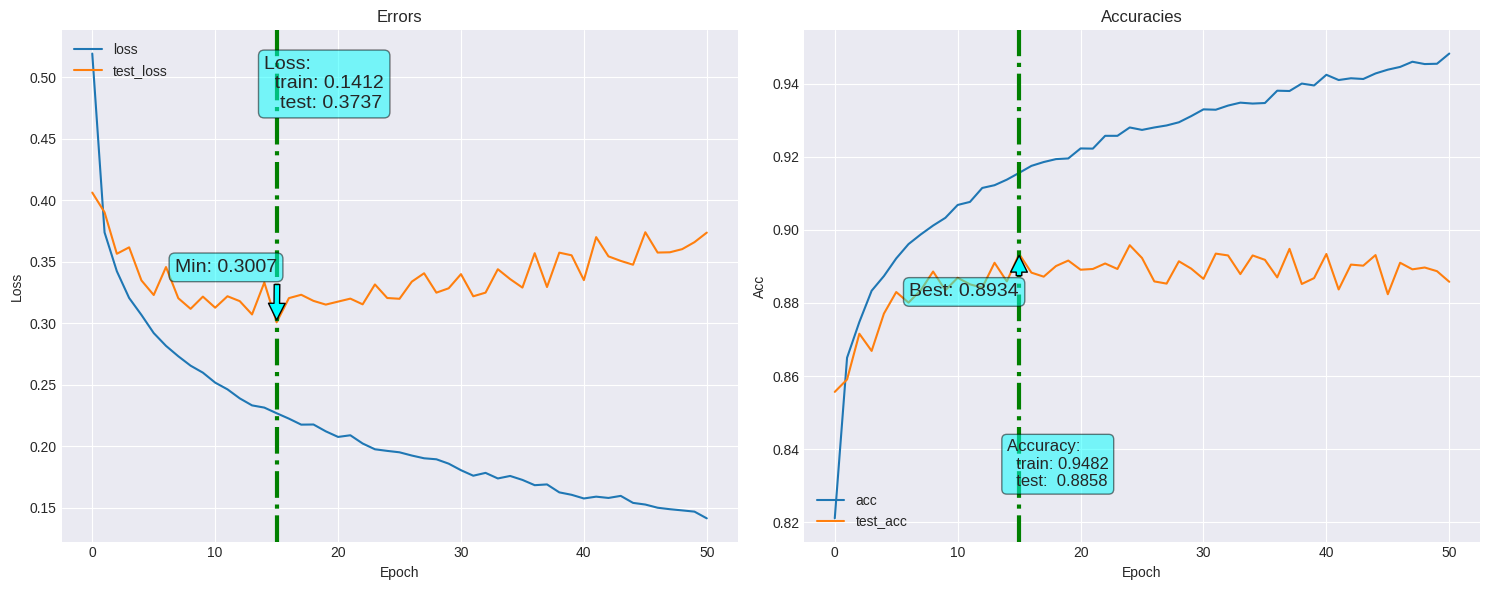

In [27]:
fn_plot_torch_hist(loss_df)

## Performance of Train Data

In [28]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    inputs, labels = data
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

In [29]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6000
           1       1.00      0.99      1.00      6000
           2       0.89      0.91      0.90      6000
           3       0.88      0.99      0.93      6000
           4       0.94      0.82      0.87      6000
           5       1.00      0.99      0.99      6000
           6       0.85      0.89      0.87      6000
           7       0.99      0.99      0.99      6000
           8       1.00      0.99      0.99      6000
           9       0.98      0.99      0.99      6000

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000



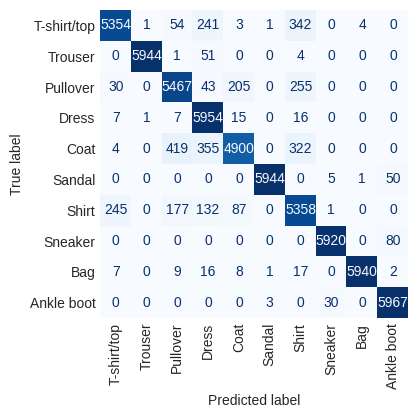

In [30]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
plt.grid(False)
plt.show();

## Performance of Test Data

In [ ]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)
    
    y_test.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

In [ ]:
print(classification_report(y_test, y_pred ))

In [ ]:
cm  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (10,10))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
plt.grid(False)
plt.show();

## Manual Simple Way

In [31]:
X = train_df.drop('label', axis = 1).to_numpy()/255
X = torch.tensor(X, dtype= torch.float32).to(device)
X

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [35]:
y_true = train_df['label'].to_numpy()

In [36]:
with torch.inference_mode(): # Learning is completed till this stage. Hence inferencing
    preds = net(X)
    y_pred = preds.argmax(dim = 1)
    y_pred = y_pred.numpy()
y_pred.shape

(60000,)

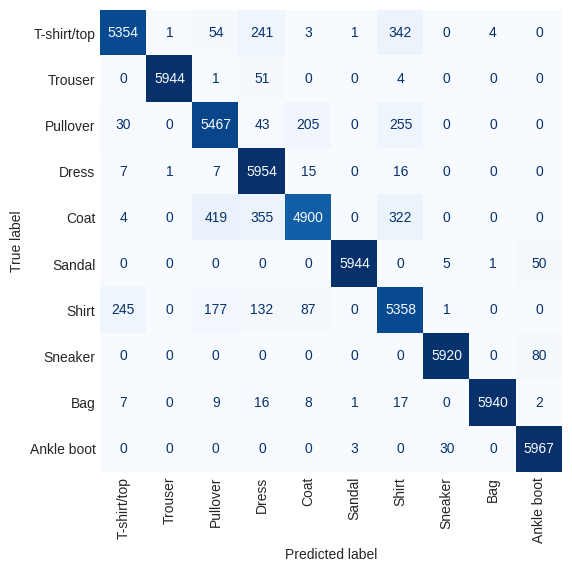

In [37]:
fn_plot_confusion_matrix(y_true, y_pred, class_labels)